In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

In [158]:
# TRAINED IN UTC TIME (MODEL MUST US UTC)
df = pd.read_csv('./data/UCY_SM_historical_with_weather.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

In [159]:
# Drop columns of SM not in use / messed up
drop_sm = ['Pac_Total-Meter-1', 'Pac_Total-Meter-2', 'Pac_Total-Meter-5', 'time']
for i in range(20, 27):
    drop_sm.append(f'Pac_Total-Meter-{i}')

df = df.drop(columns=drop_sm)
df = df.dropna()

In [160]:
# Get rid of outliers
df_clean = df.copy()
def remove_outliers(df, column):
    # Q1 = df[column].quantile(0.25)
    # Q3 = df[column].quantile(0.75)
    # IQR = Q3 - Q1
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 100000 * IQR

    return df[df[column] < 100000000]

df_clean = remove_outliers(df_clean, 'Total_Pac_MW')
for i in range(3, 17):
    if i != 9 and i != 5:
        df_clean = remove_outliers(df_clean, f'Pac_Total-Meter-{i}')

df.shape[0] - df_clean.shape[0]

79

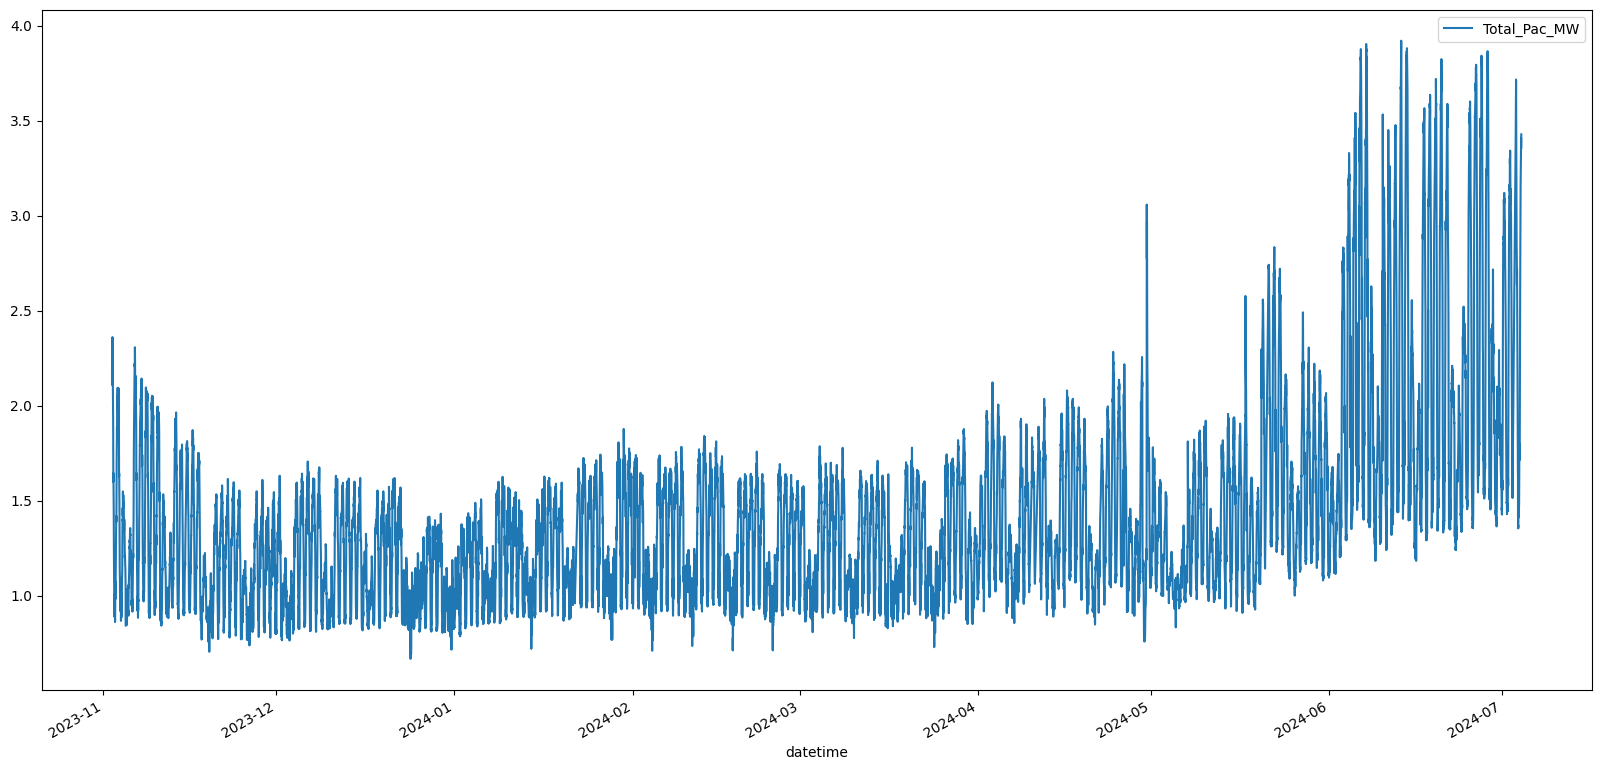

In [161]:
_ = df_clean.plot(x='datetime', y='Total_Pac_MW', figsize=(20, 10))

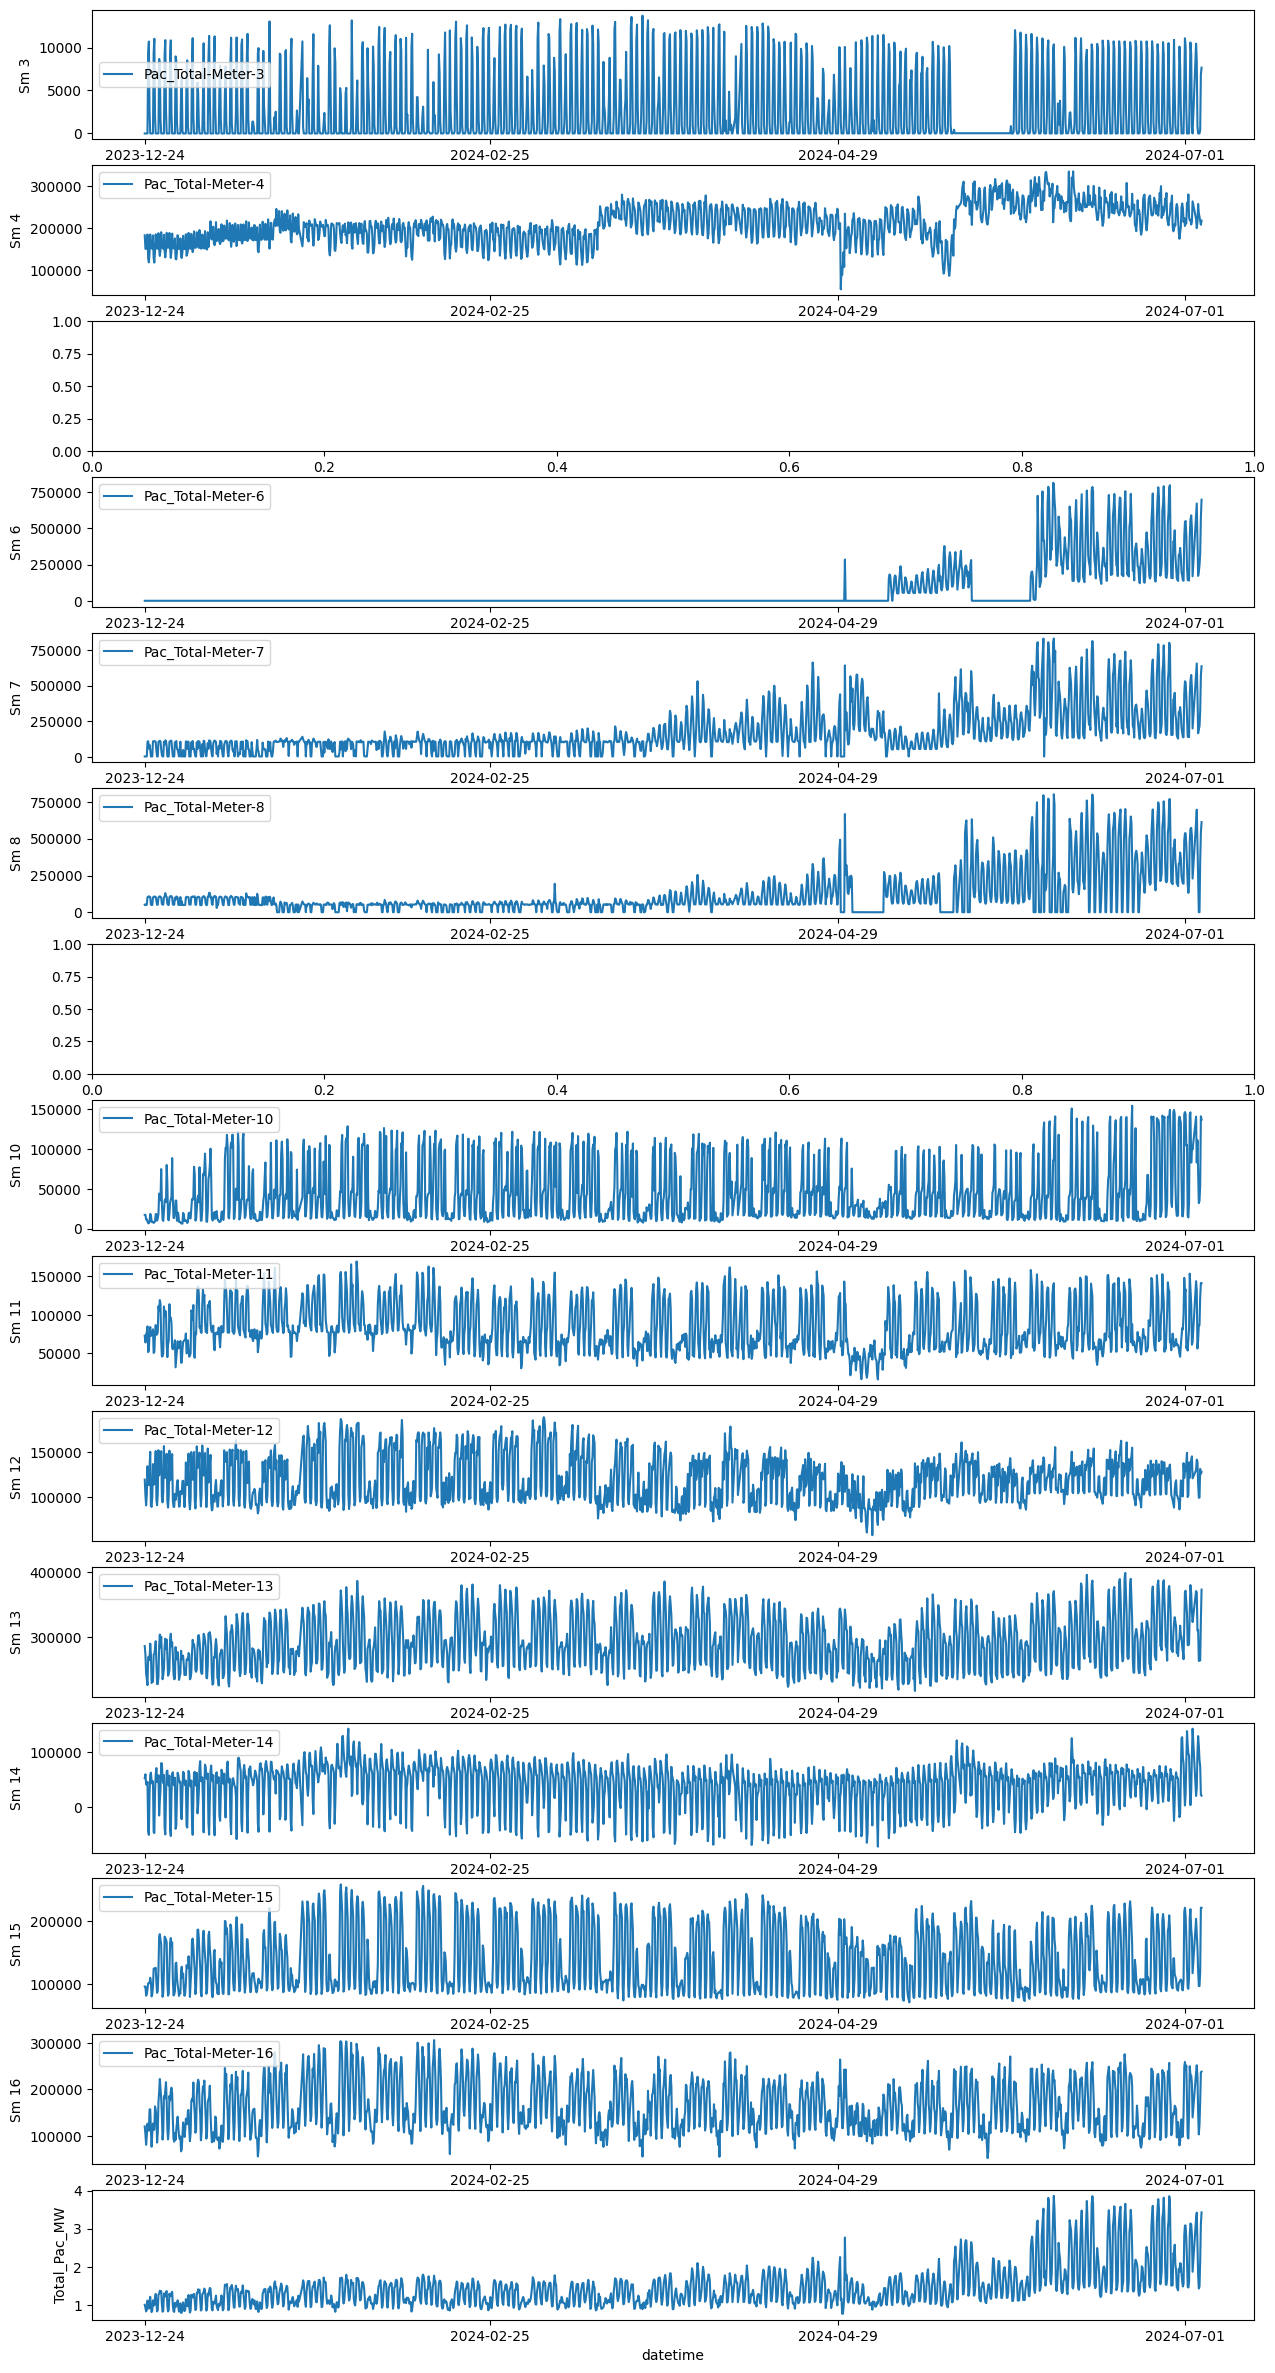

In [30]:
# Create subplots
df_for_plot = df_clean[5000:]
df_for_plot = df_for_plot.iloc[::12]
fig, axs = plt.subplots(15, 1, figsize=(15, 30))

# Plot 'Total_Pac_MW' and 'Pac_Total-Meter-{i}' columns for all i from 3 to 16
for i in range(3, 17):
    if not i == 9 and not i == 5:
        axs[i-3].plot(df_for_plot['datetime'], df_for_plot[f'Pac_Total-Meter-{i}'], label=f'Pac_Total-Meter-{i}')
        axs[i-3].set_xlabel('datetime')
        axs[i-3].set_xticks(df_for_plot['datetime'][::500])
        axs[i-3].set_ylabel(f'Sm {i}')
        axs[i-3].legend()

axs[14].plot(df_for_plot['datetime'], df_for_plot['Total_Pac_MW'], label='Total_Pac_MW')
axs[14].set_xlabel('datetime')
axs[14].set_xticks(df_for_plot['datetime'][::500])
axs[14].set_ylabel('Total_Pac_MW')

# Show the plot
plt.show()

In [162]:
# Create features 
def create_features(_df):
    df = _df.copy()
    df['minute'] = df['datetime'].dt.minute + df['datetime'].dt.hour * 60
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['month'] = df['datetime'].dt.month

    # df['lag_1'] = df['Total_Pac_MW'].shift(96)
    # df['lag_2'] = df['Total_Pac_MW'].shift(192)
    # df['lag_3'] = df['Total_Pac_MW'].shift(288)
    df = df.dropna()
    
    return df[['minute', 'day_of_week', 'day_of_year', 'month', 'Tamb-temp', 'humidity', 'precipMM', 'GHI-GhPyr']], df['Total_Pac_MW']

In [163]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=25, test_size=24*4*7)

[0]	validation_0-rmse:0.23811	validation_1-rmse:0.18087
[75]	validation_0-rmse:0.04624	validation_1-rmse:0.08279
[0]	validation_0-rmse:0.23409	validation_1-rmse:0.17952
[83]	validation_0-rmse:0.04473	validation_1-rmse:0.10180
[0]	validation_0-rmse:0.23128	validation_1-rmse:0.25541
[100]	validation_0-rmse:0.04315	validation_1-rmse:0.11636
[200]	validation_0-rmse:0.03667	validation_1-rmse:0.10940
[256]	validation_0-rmse:0.03449	validation_1-rmse:0.11017
[0]	validation_0-rmse:0.22733	validation_1-rmse:0.19881
[100]	validation_0-rmse:0.04535	validation_1-rmse:0.08377
[200]	validation_0-rmse:0.03915	validation_1-rmse:0.08237
[300]	validation_0-rmse:0.03539	validation_1-rmse:0.08167
[332]	validation_0-rmse:0.03449	validation_1-rmse:0.08258
[0]	validation_0-rmse:0.22779	validation_1-rmse:0.22635
[100]	validation_0-rmse:0.04829	validation_1-rmse:0.09000
[200]	validation_0-rmse:0.04203	validation_1-rmse:0.08738
[204]	validation_0-rmse:0.04188	validation_1-rmse:0.08774
[0]	validation_0-rmse:0.22

/Users/alextseng/Documents/ucy-pv-forecasting/.venv/lib/python3.11/site-packages/xgboost/plotting.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1)


[74]	validation_0-rmse:0.07967	validation_1-rmse:0.28729
[0]	validation_0-rmse:0.32212	validation_1-rmse:1.04102
[100]	validation_0-rmse:0.08035	validation_1-rmse:0.41710
[200]	validation_0-rmse:0.06939	validation_1-rmse:0.40756
[215]	validation_0-rmse:0.06854	validation_1-rmse:0.40910
[0]	validation_0-rmse:0.36314	validation_1-rmse:0.88071
[100]	validation_0-rmse:0.08411	validation_1-rmse:0.40332
[200]	validation_0-rmse:0.07143	validation_1-rmse:0.39657
[267]	validation_0-rmse:0.06624	validation_1-rmse:0.39600
[0]	validation_0-rmse:0.38751	validation_1-rmse:0.76975
[80]	validation_0-rmse:0.09344	validation_1-rmse:0.32511
Average RMSE: 0.15824697095029389
Individual RMSE Scores: [0.06963599351282652, 0.09686662267406727, 0.10913812672276668, 0.08162551065614068, 0.0868271769511428, 0.07379974880096021, 0.06671722967051848, 0.05932943626297195, 0.062015206735823135, 0.15010055897854852, 0.10745360122826625, 0.11195966852535943, 0.0879183533339963, 0.07793644642765699, 0.0756036005288892

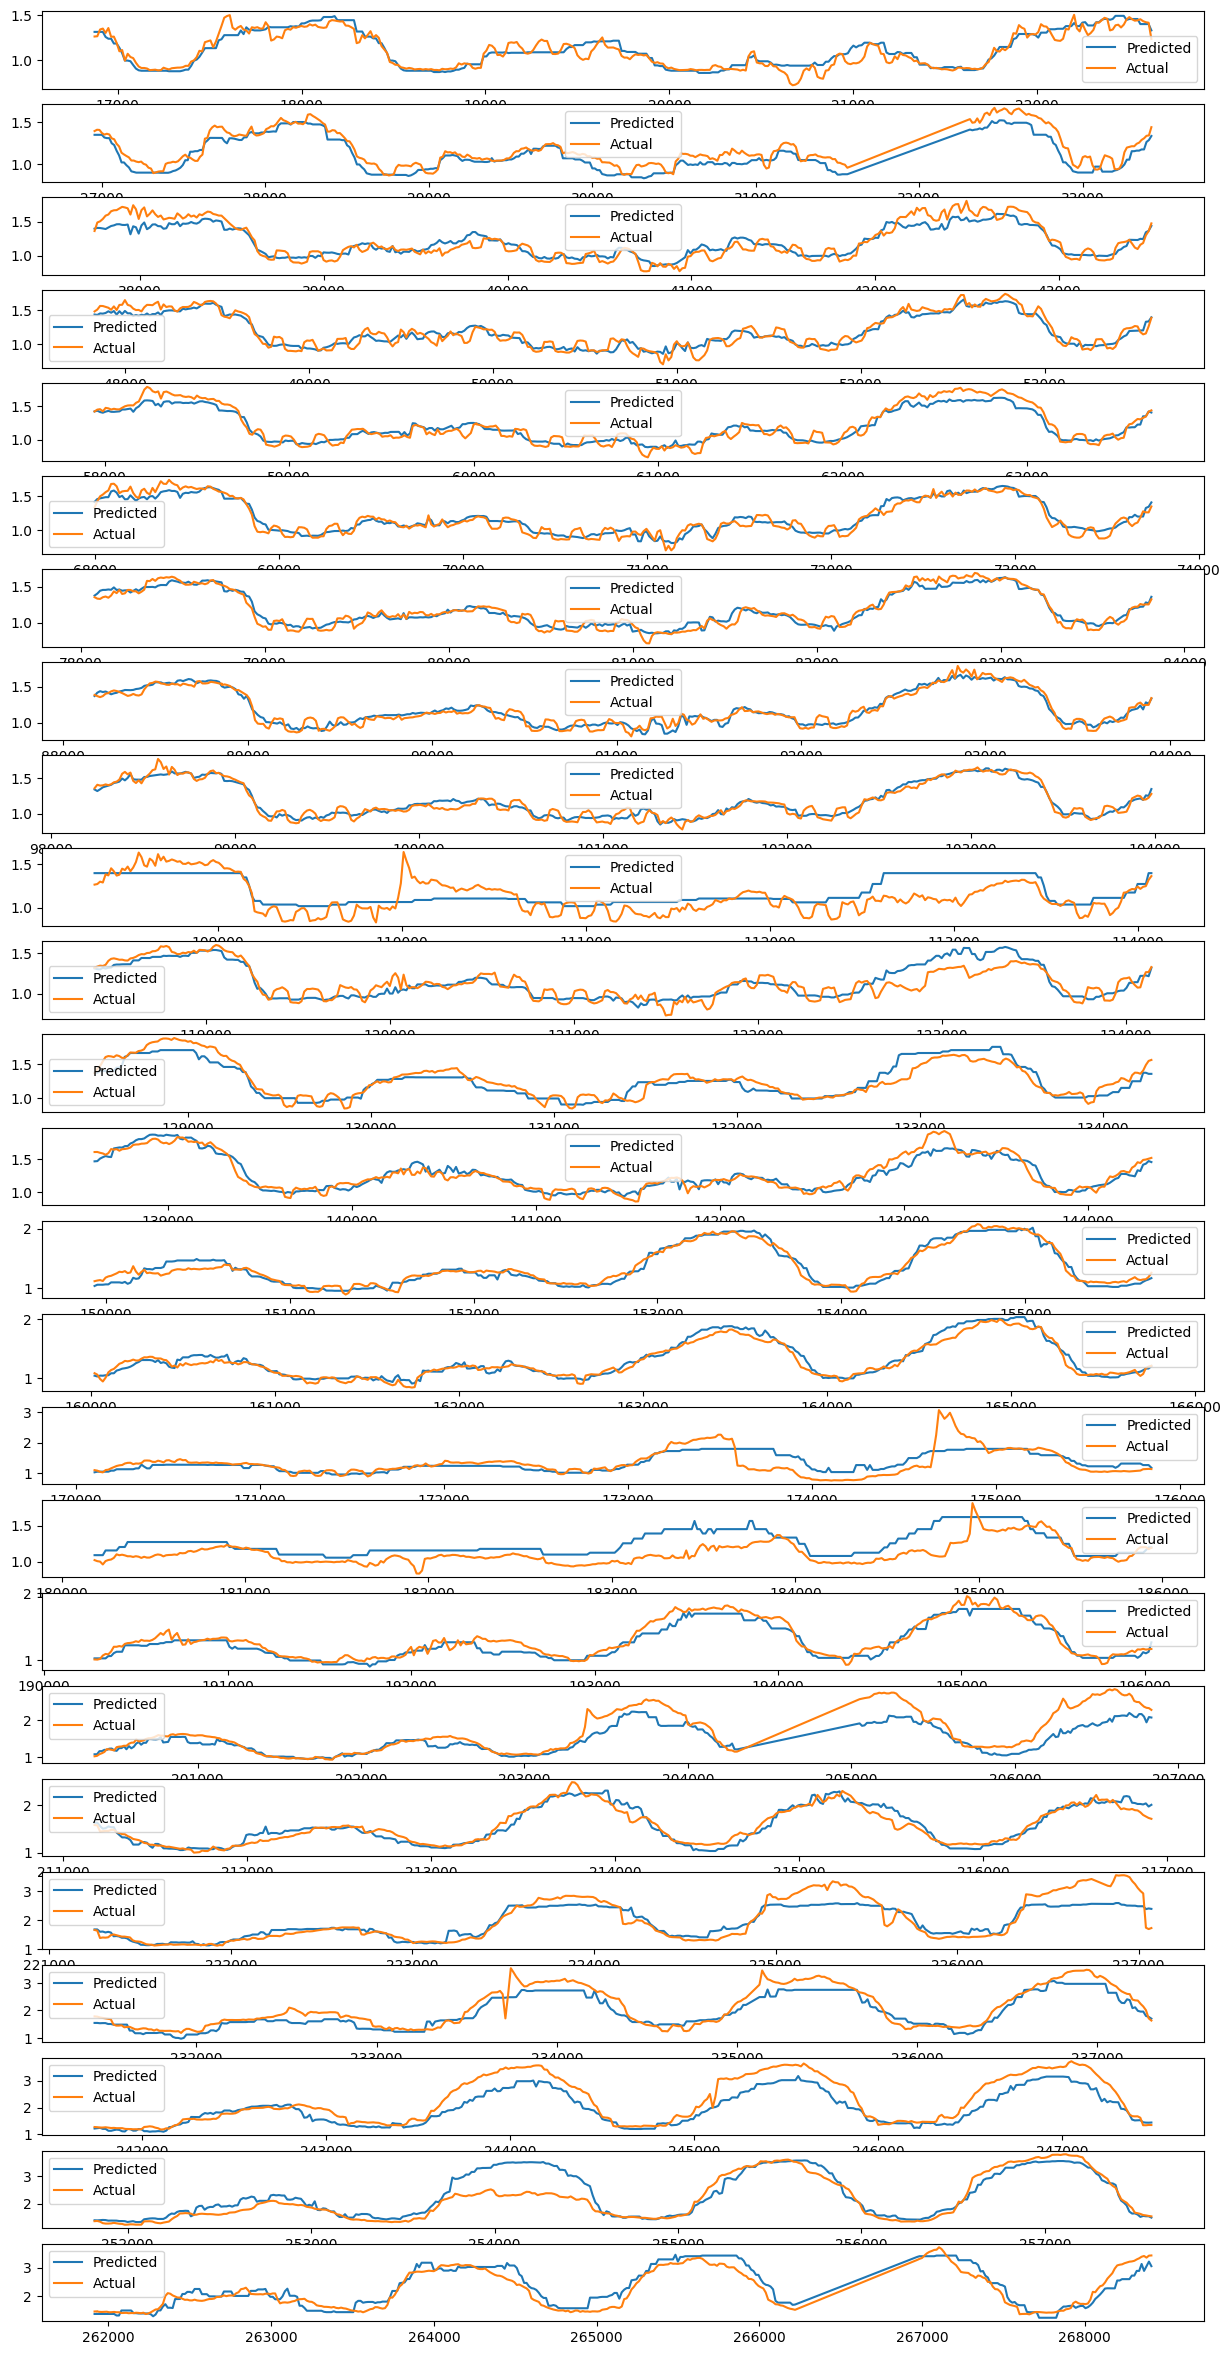

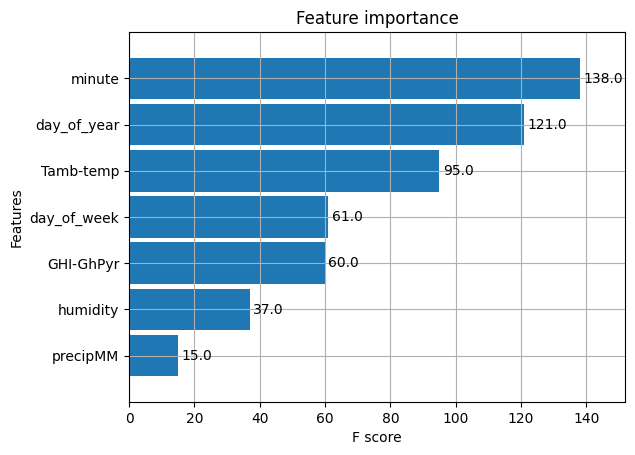

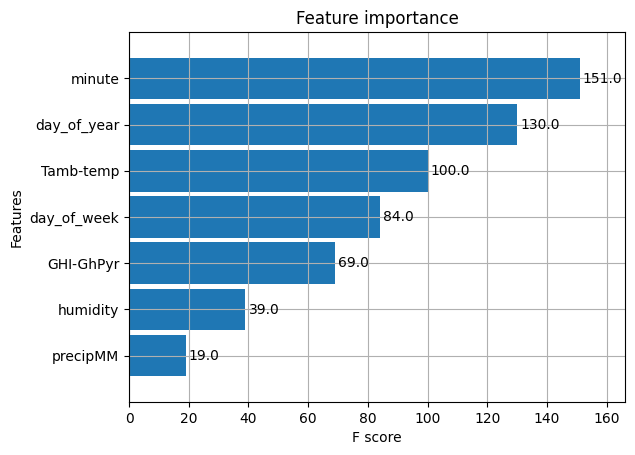

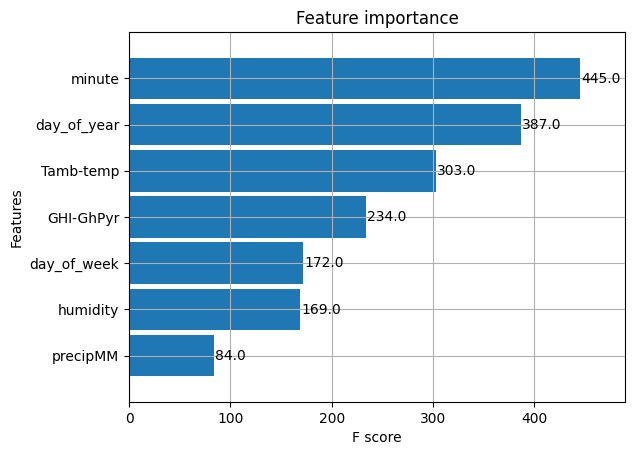

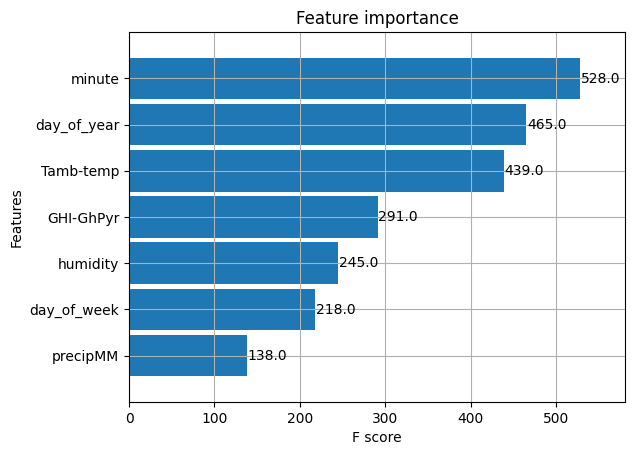

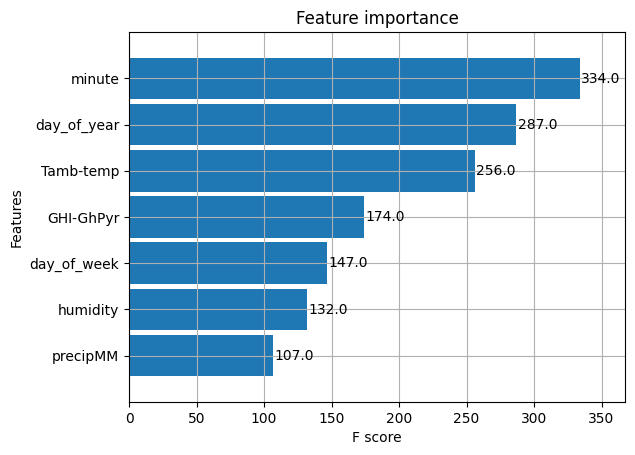

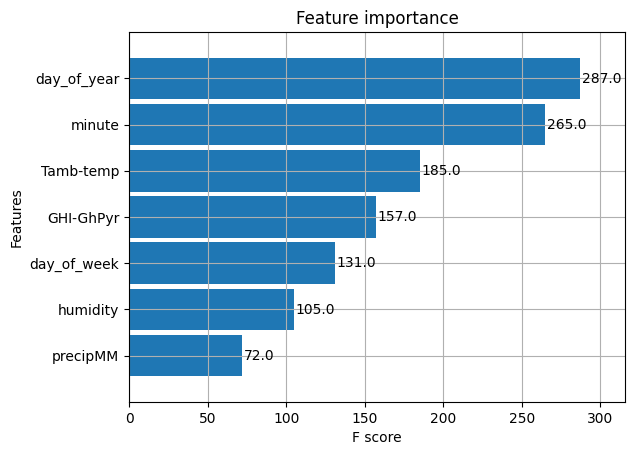

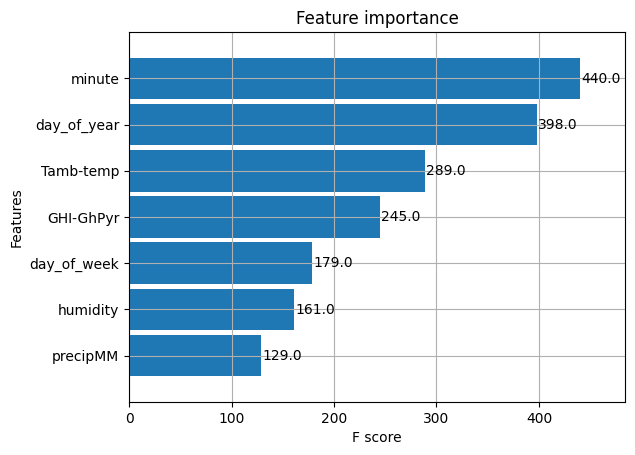

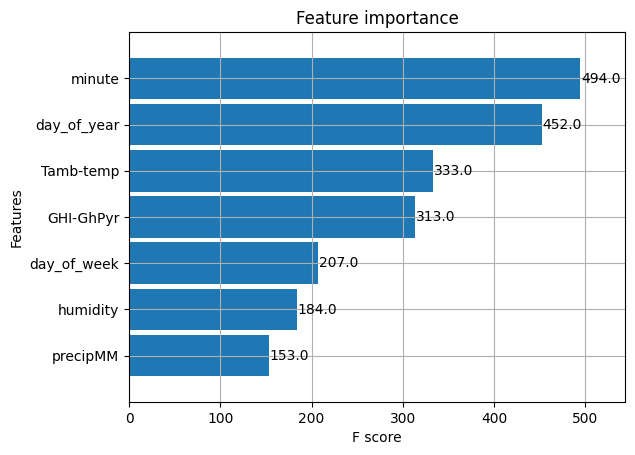

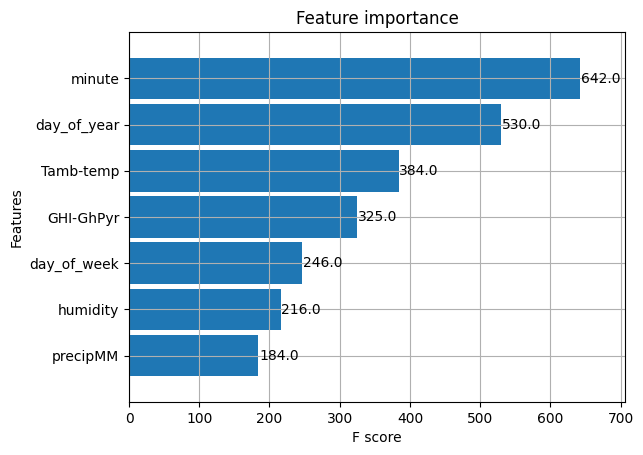

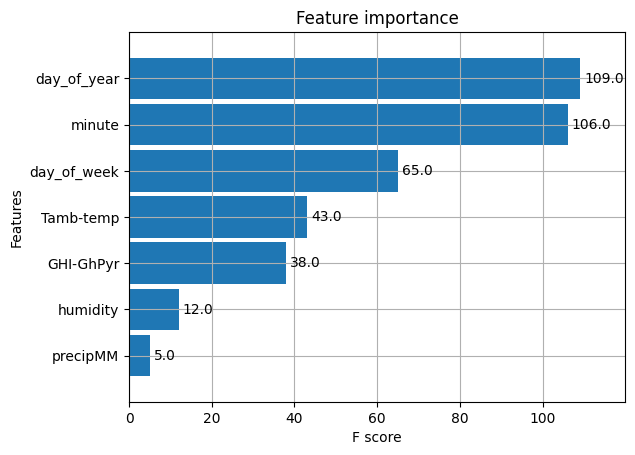

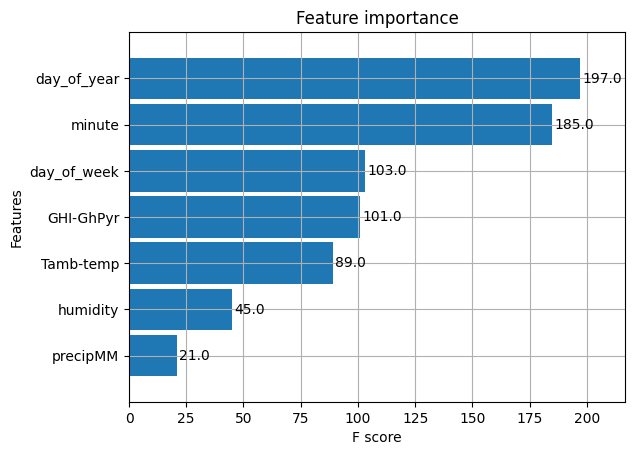

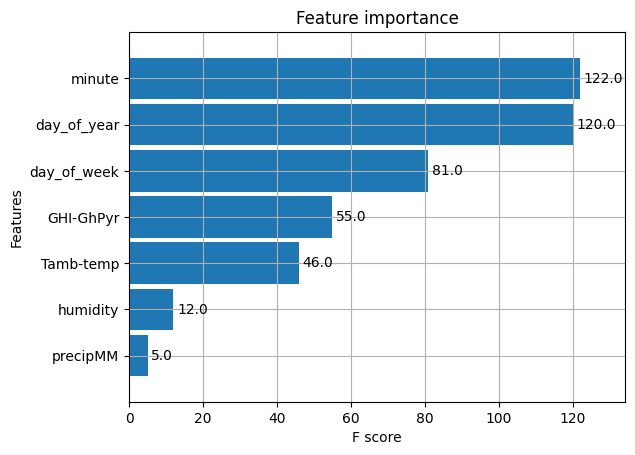

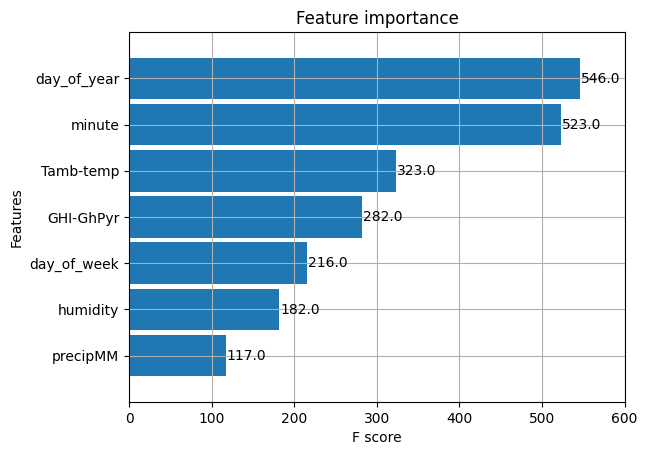

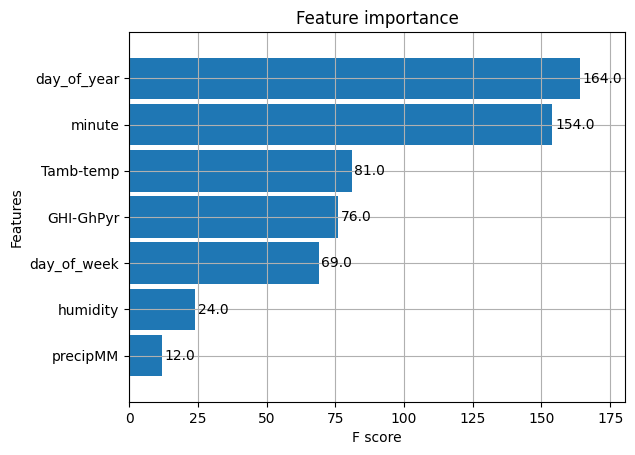

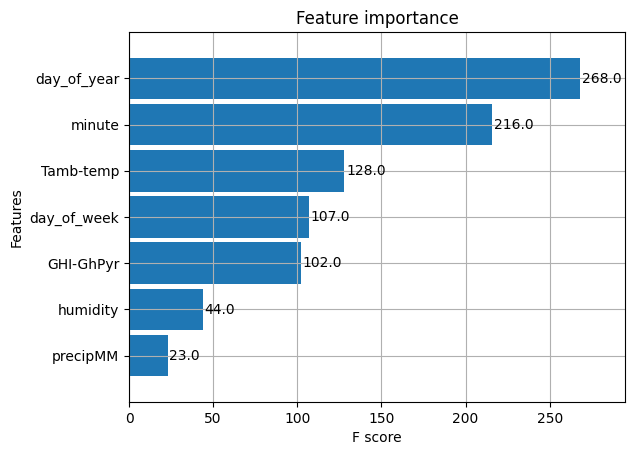

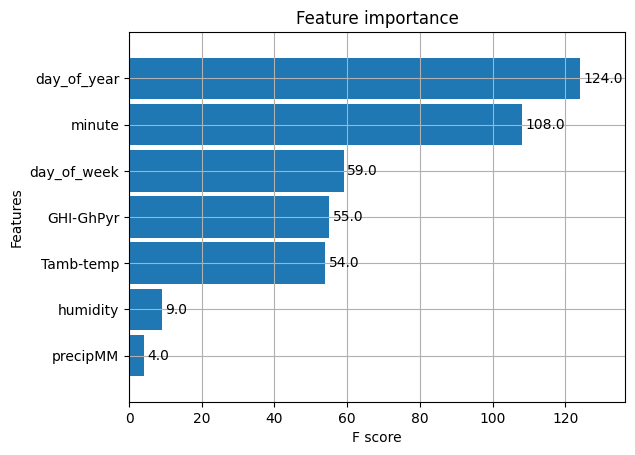

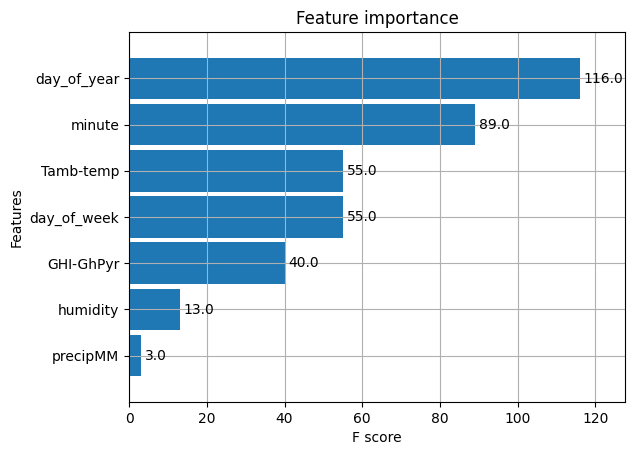

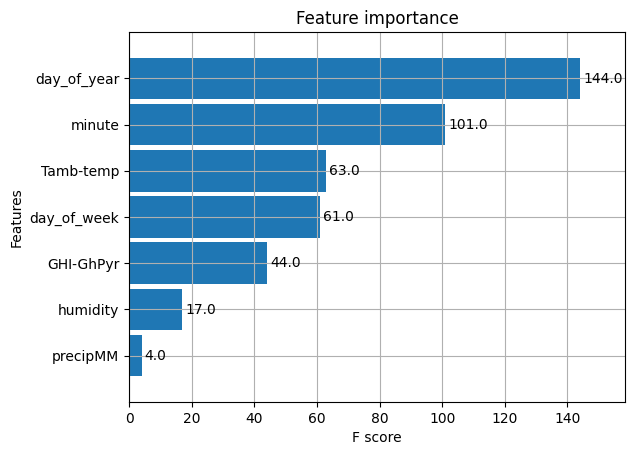

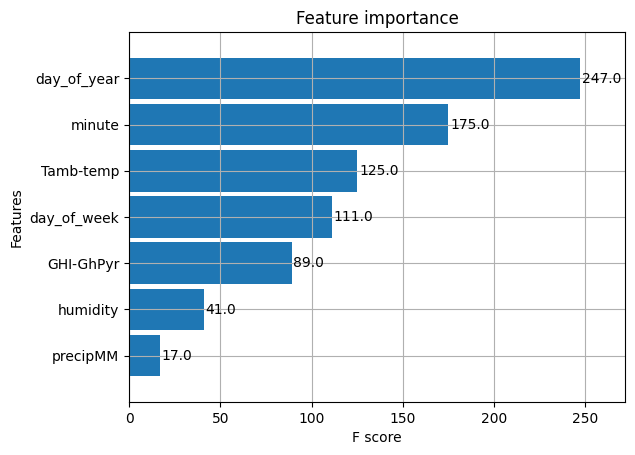

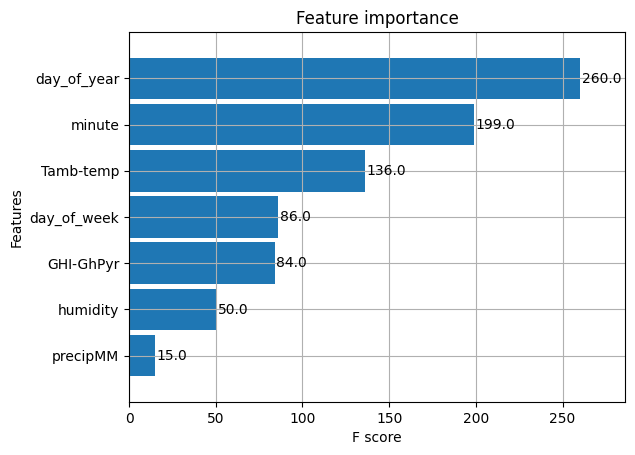

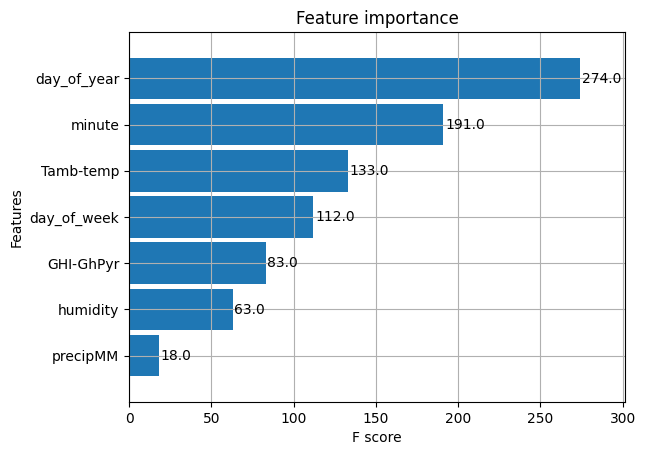

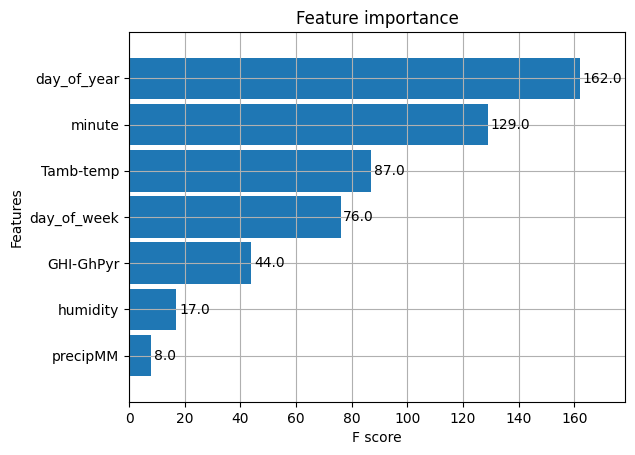

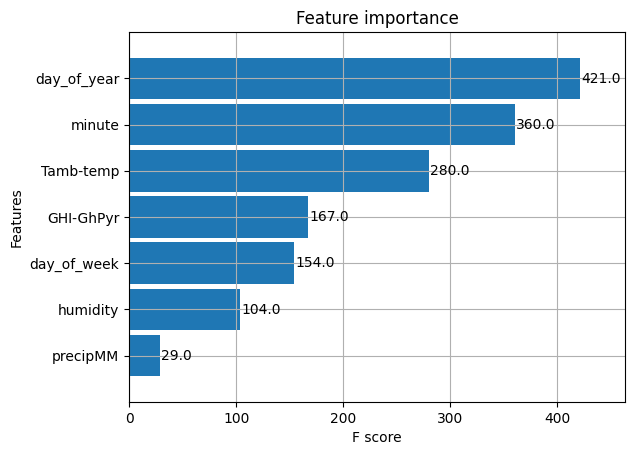

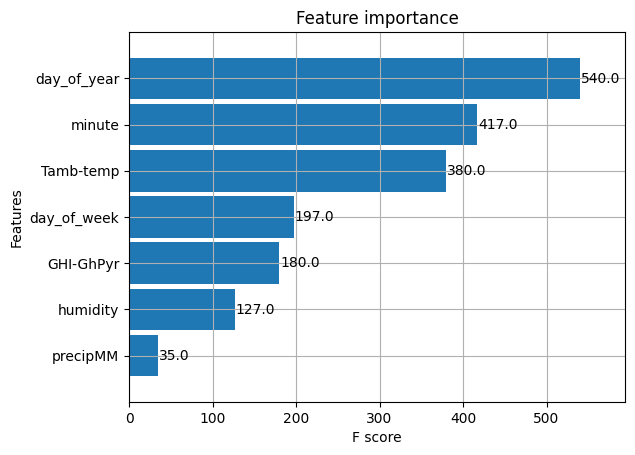

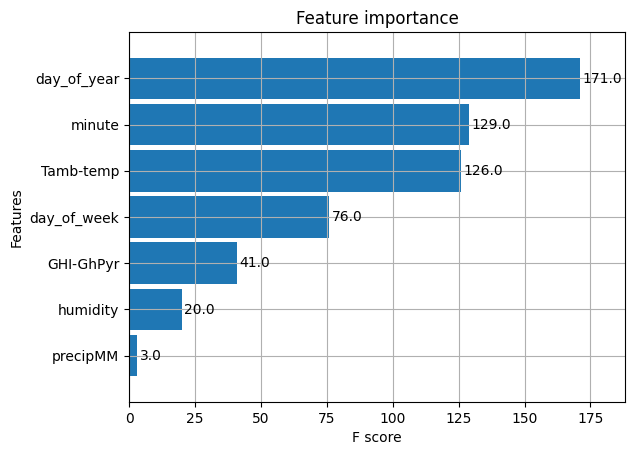

In [164]:
# Time series cross validation testing

from sklearn.metrics import mean_squared_error
from xgboost import plot_importance


fold = 0
preds = []
scores = []
pred_indxs = []
regs = []
# tuned_preds = []
fig, axs = plt.subplots(25, 1, figsize=(15, 30))
i = 0

for train_idx, test_idx in tss.split(df_clean):
    df_train = df_clean.iloc[train_idx]
    df_test = df_clean.iloc[test_idx]
    pred_indxs.append(test_idx)

    X_train, y_train = create_features(df_train)
    X_test, y_test = create_features(df_test)

    reg = xgb.XGBRegressor(n_estimators=3000, objective='reg:squarederror', n_jobs=-1, max_depth=3)
    reg.set_params(
    eval_metric='rmse',
    early_stopping_rounds=50
    )
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    regs.append(reg)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    X_test['graph_min'] = (X_test['minute'] + ((X_test['day_of_year']) * 24 * 60))
    axs[i].plot(X_test['graph_min'], y_pred, label='Predicted')
    axs[i].plot(X_test['graph_min'], y_test, label='Actual')
    axs[i].legend()
    _ = plot_importance(reg, height=0.9)

    i += 1


print(f'Average RMSE: {np.mean(scores)}')
print(f'Individual RMSE Scores: {scores}')
plt.show()

In [146]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [165]:
all_features, all_correct = create_features(df_clean)
avg_MAPE = 0
for reg in regs:
    all_predictions = reg.predict(all_features)
    avg_MAPE += mean_absolute_percentage_error(all_correct, all_predictions)

avg_MAPE /= len(regs)
print(f'Average MAPE: {avg_MAPE}')


Average MAPE: 8.546724960692414


In [166]:
# save each regressor to its own file
for i, reg in enumerate(regs):
    reg.save_model(f'xgboost_load_model_{i}.bin')

/Users/alextseng/Documents/ucy-pv-forecasting/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
